In [1]:
import xarray as xr
import numpy as np
from minisom import MiniSom
import pandas as pd
from sklearn.preprocessing import RobustScaler
import pprint
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.gridspec import GridSpec 
import matplotlib.colors as mcolors
from matplotlib import colormaps as cm
import matplotlib.gridspec as gridspec 
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

from som_2var_training import read_and_transform, build_scaler, train_som

In [2]:
prefs = {'filename': "./Datasets/combine_pwat_z500_inits.nc", 
         'var1': 'z500', 'var2': 'pwat', 'wlon': 220, 'elon': 305, 'nlat': 55, 'slat': 20, 
         'som_config': {'x': 4, 'y': 4, 'sigma': 0.5, 'random_seed': 42},
         'som_train': {'num_iteration': 10000, 'random_order': True, 'verbose': True}}

trained_som, trained_scaler, train_info, xr_data = train_som(prefs)


current model configuration
{'input_len': 24282, 'random_seed': 42, 'sigma': 0.5, 'x': 4, 'y': 4}
current training configuration
{'data': array([[-0.20787   , -0.23133911, -0.24382445, ..., -0.39776176,
        -0.19108878, -0.1742262 ],
       [-1.4184133 , -1.4353495 , -1.4344262 , ..., -1.1606435 ,
        -1.0643088 , -1.0463164 ],
       [ 0.2818785 ,  0.26043582,  0.24609436, ..., -1.0347401 ,
        -0.9122647 , -0.8908087 ],
       ...,
       [-0.37288073, -0.36255017, -0.34266713, ...,  0.16134287,
        -0.06155263, -0.45548353],
       [-0.9060967 , -0.880783  , -0.8457077 , ..., -0.27605513,
        -0.05695932, -0.07295413],
       [-0.7406267 , -0.7585039 , -0.7617178 , ..., -0.5390535 ,
        -0.5787782 , -0.5821934 ]], dtype=float32),
 'num_iteration': 10000,
 'random_order': True,
 'verbose': True}
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 74.2098576047692


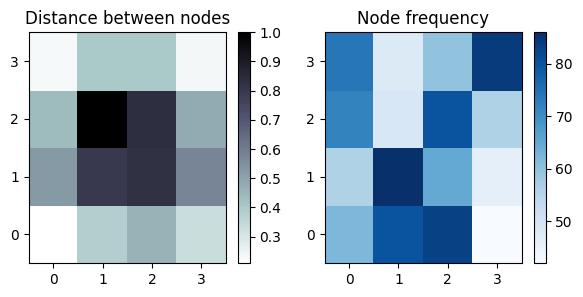

In [3]:
plt.rcParams['figure.figsize'] = 7, 3
x = [x+0.5 for x in range(train_info['som_config']['x'])]
y = [y+0.5 for y in range(train_info['som_config']['y'])]

ax = plt.subplot(1, 2, 1)
ax.set_yticks(y, range(train_info['som_config']['y']))
ax.set_xticks(x, range(train_info['som_config']['x']))
ax.set_title("Distance between nodes")
mmp = ax.pcolor(trained_som.distance_map().T, cmap='bone_r')
plt.colorbar(mmp, ax=ax)

ax = plt.subplot(1, 2, 2)
ax.set_yticks(y, range(train_info['som_config']['y']))
ax.set_xticks(x, range(train_info['som_config']['x']))
ax.set_title("Node frequency")
mmp = ax.pcolor(trained_som.activation_response(train_info['som_train']['data']).T, cmap='Blues')
plt.colorbar(mmp, ax=ax)

In [4]:
win_map_idx = trained_som.win_map(train_info['som_train']['data'], return_indices = True)

In [5]:
win_map = trained_som.win_map(train_info['som_train']['data'])

z500_avg_data = [
    np.reshape(
        trained_scaler.inverse_transform([np.mean(win_map[node], axis=0)])[0][:12141],
        (len(xr_data.lat), len(xr_data.lon))
    )
    for node in sorted(win_map.keys())
]

z500_frequencies = trained_som.activation_response(train_info['som_train']['data']).flatten()


pwat_avg_data = [
    np.reshape(
        trained_scaler.inverse_transform([np.mean(win_map[node], axis=0)])[0][12141:],
        (len(xr_data.lat), len(xr_data.lon))
    )
    for node in sorted(win_map.keys())
]

pwat_frequencies = trained_som.activation_response(train_info['som_train']['data']).flatten()


length, width = prefs['som_config']['x'], prefs['som_config']['y']

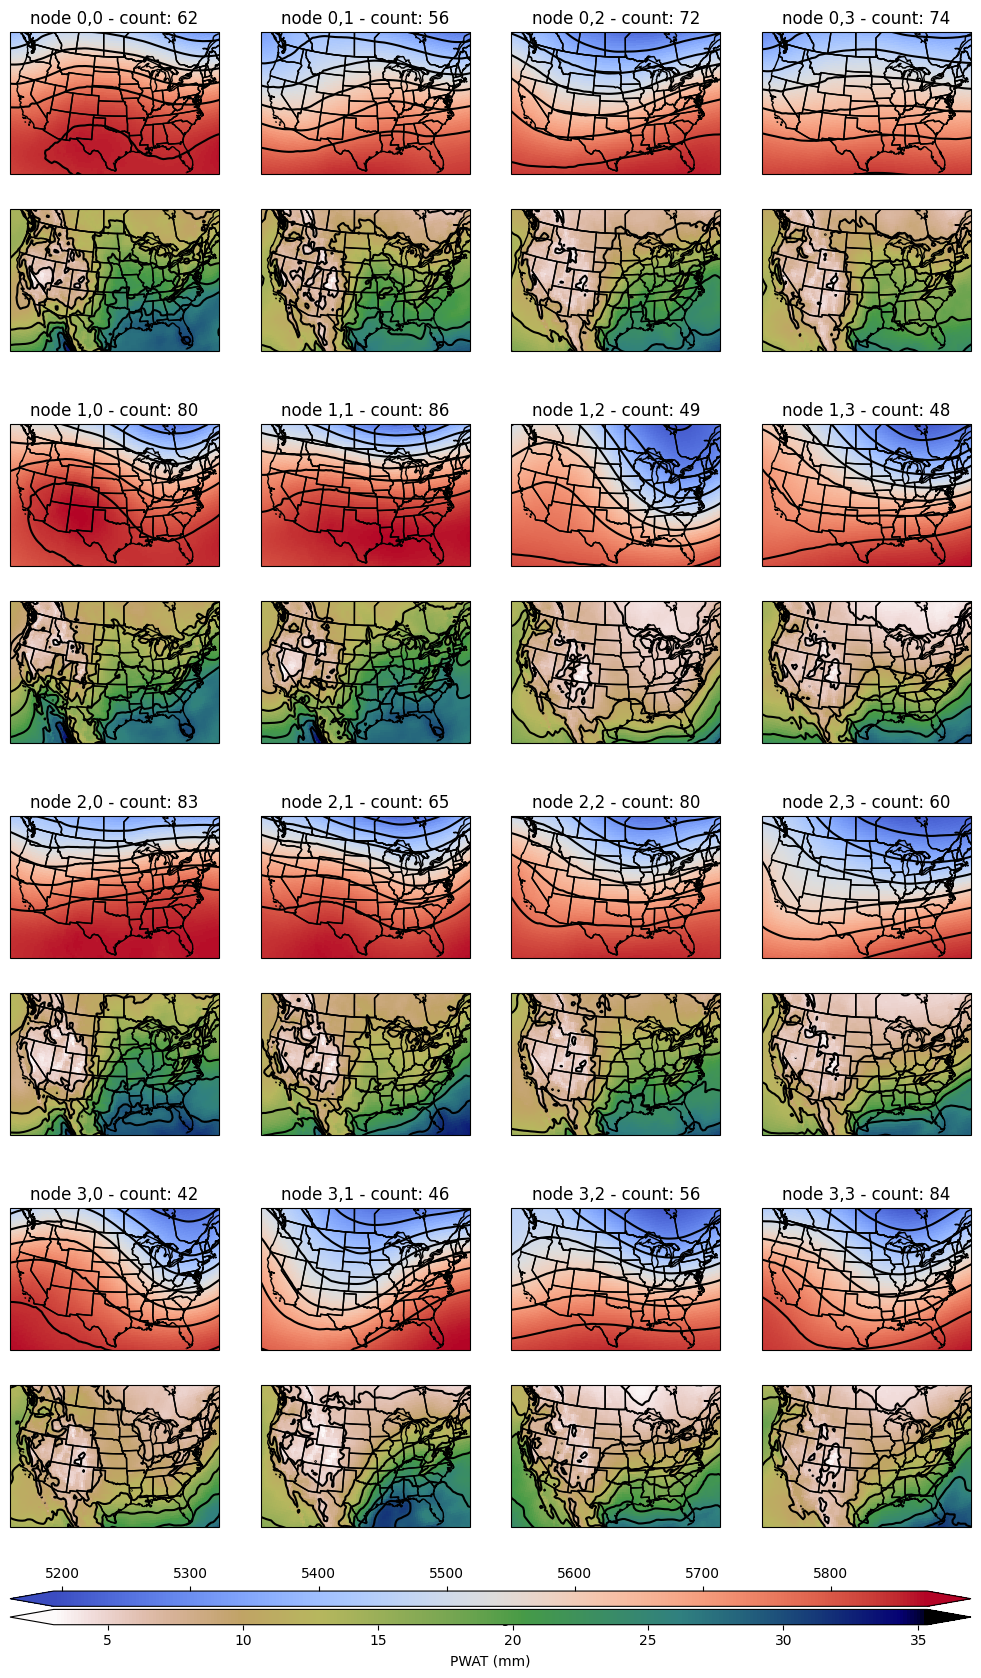

In [6]:
import matplotlib.gridspec as gridspec

# np.reshape(z500_avg_data, (4, 4, 71, 171))
# np.reshape(pwat_avg_data, (4, 4, 71, 171))

vmin_z500 = np.min(z500_avg_data)
vmax_z500 = np.max(z500_avg_data)
norm_z500 = mcolors.Normalize(vmin= vmin_z500, vmax= vmax_z500)

vmin_pwat = np.min(pwat_avg_data)
vmax_pwat = np.max(pwat_avg_data)
norm_pwat = mcolors.Normalize(vmin=vmin_pwat, vmax=vmax_pwat)


fig = plt.figure(figsize=(3.1 * length, 2 * 2.6 * width))


outer = GridSpec(nrows= length + 1, ncols= width, figure= fig, height_ratios = [1] * length + [0.1])

for i in range(length):
    for j in range(width):
        node_idx = i * width + j
        inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[i, j], hspace= 0.1, wspace= 0.05)
        
        ax_z500 = fig.add_subplot(inner[0,0], projection= ccrs.LambertConformal())
        ax_z500.set_title(f'node {i},{j} - count: {int(pwat_frequencies[node_idx])}')
        ax_z500.set_extent([xr_data.lon.values.min() - 340, xr_data.lon.values.max() - 380, xr_data.lat.values.min() + 3, xr_data.lat.values.max() - 3])
        zcm = ax_z500.pcolormesh(xr_data.lon, xr_data.lat, z500_avg_data[node_idx], cmap= 'coolwarm', transform= ccrs.PlateCarree())
        zct = ax_z500.contour(xr_data.lon, xr_data.lat, z500_avg_data[node_idx], colors= 'k', transform= ccrs.PlateCarree())
        ax_z500.add_feature(cfeature.BORDERS)
        ax_z500.add_feature(cfeature.STATES)
        
        ax_pwat = fig.add_subplot(inner[1, 0], projection= ccrs.LambertConformal())
        ax_pwat.set_extent([xr_data.lon.values.min() - 340, xr_data.lon.values.max() - 380, xr_data.lat.values.min() + 3, xr_data.lat.values.max() - 3])
        pcm = ax_pwat.pcolormesh(xr_data.lon, xr_data.lat, pwat_avg_data[node_idx], cmap= 'gist_earth_r', transform= ccrs.PlateCarree())
        pct = ax_pwat.contour(xr_data.lon, xr_data.lat, pwat_avg_data[node_idx], colors= 'k', transform= ccrs.PlateCarree())
        ax_pwat.add_feature(cfeature.BORDERS)
        ax_pwat.add_feature(cfeature.STATES)


cax_inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec= outer[-1, :])        
cax_z500 = fig.add_subplot(cax_inner[0, 0])
cax_pwat = fig.add_subplot(cax_inner[1, 0])

cb_z500 = fig.colorbar(zcm, cax= cax_z500, orientation= 'horizontal', extend= 'both')
cb_z500.ax.xaxis.set_ticks_position('top')
cb_z500.ax.xaxis.set_ticks_position('top')
cb_z500.ax.tick_params(labeltop= True, labelbottom= False)
cb_z500.set_label('500 hPa heights (m)')
fig.colorbar(pcm, cax= cax_pwat, orientation= 'horizontal', extend= 'both', label= 'PWAT (mm)')
#plt.savefig('./Figures/combined_z500_pwat.png', bbox_inches= 'tight')

In [7]:
ds, npy, scaler = build_scaler(prefs)

scaled_npy = scaler.transform(npy)

In [8]:
scaled_npy.shape

(1043, 24282)

In [9]:
def find_best_samples(scaled_npy, trained_som):
    
    weights = trained_som.get_weights() # shape (nx, ny, 2*(lat*lon), represents the weight vector of each node
    
    nx, ny, nfeats = weights.shape 
    
    win_map_idx = trained_som.win_map(scaled_npy, return_indices=True)

    closest_match_idx = {}

    for i in range(nx):
        for j in range(ny):
            idx = np.asarray(win_map_idx[(i, j)], dtype=int)
            diffs = scaled_npy[idx] - weights[i, j]       # Compute difference for linalg.norm
            d = np.linalg.norm(diffs, axis=1)             # Euclidean distances (K,)
            best = idx[np.argmin(d)]                       # this is the best sample index in scaled_npy

            closest_match_idx[(i, j)] = best

    return closest_match_idx

In [10]:
best_samples = find_best_samples(scaled_npy, trained_som)

In [11]:
best_samples

{(0, 0): 1017,
 (0, 1): 174,
 (0, 2): 1008,
 (0, 3): 881,
 (1, 0): 657,
 (1, 1): 240,
 (1, 2): 4,
 (1, 3): 886,
 (2, 0): 962,
 (2, 1): 612,
 (2, 2): 230,
 (2, 3): 632,
 (3, 0): 258,
 (3, 1): 839,
 (3, 2): 59,
 (3, 3): 583}

In [12]:
first = ds.sel(time = ds.time[174])

first

<xarray.Dataset> Size: 98kB
Dimensions:  (lat: 71, lon: 171)
Coordinates:
    time     datetime64[ns] 8B 2003-05-07
  * lat      (lat) float32 284B 55.0 54.5 54.0 53.5 53.0 ... 21.5 21.0 20.5 20.0
  * lon      (lon) float32 684B 220.0 220.5 221.0 221.5 ... 304.0 304.5 305.0
Data variables:
    z500     (lat, lon) float32 49kB 5.444e+03 5.434e+03 ... 5.861e+03 5.859e+03
    pwat     (lat, lon) float32 49kB 9.165 8.892 8.864 ... 31.94 32.59 33.12

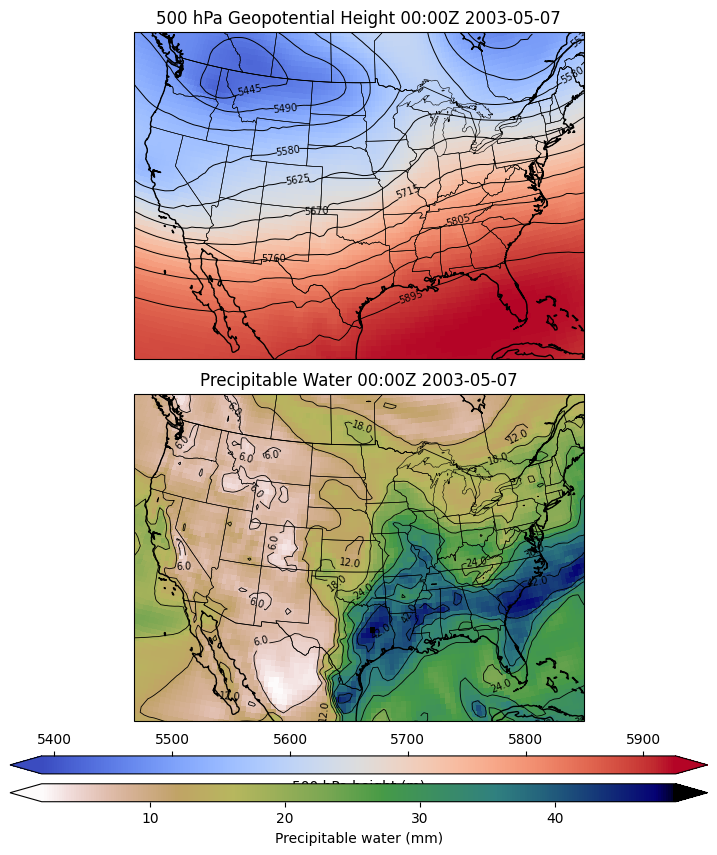

In [13]:
lat = first.lat
lon = first.lon

# Match original extent logic
extent = [
    lon.values.min() - 340,
    lon.values.max() - 380,
    lat.values.min() + 3,
    lat.values.max() - 3,
]

proj = ccrs.LambertConformal(central_longitude=float(lon.mean()))

fig = plt.figure(figsize=(9, 10))
outer = GridSpec(nrows=3, ncols=1, figure=fig, height_ratios=[1, 1, 0.14], hspace=0.15)

# ── Z500 (top) ──
ax_z500 = fig.add_subplot(outer[0, 0], projection=proj)
ax_z500.set_title(f'500 hPa Geopotential Height 00:00Z {str(first.time.values).split("T")[0]}')
ax_z500.set_extent(extent, crs=ccrs.PlateCarree())

zcm = ax_z500.pcolormesh(lon, lat, first.z500, cmap='coolwarm',
                         transform=ccrs.PlateCarree(), shading='auto')
zct = ax_z500.contour(lon, lat, first.z500, colors='k', linewidths=0.7,  levels = np.arange(4500, 6300, 45),
                      transform=ccrs.PlateCarree())
ax_z500.clabel(zct, fmt="%.0f", inline=True, fontsize=7)
ax_z500.add_feature(cfeature.BORDERS, linewidth=0.6)
ax_z500.add_feature(cfeature.STATES, linewidth=0.4)
ax_z500.coastlines()

# ── PWAT (bottom) ──
ax_pwat = fig.add_subplot(outer[1, 0], projection=proj)
ax_pwat.set_title(f'Precipitable Water 00:00Z {str(first.time.values).split("T")[0]}')
ax_pwat.set_extent(extent, crs=ccrs.PlateCarree())

pcm = ax_pwat.pcolormesh(lon, lat, first.pwat, cmap='gist_earth_r',
                         transform=ccrs.PlateCarree(), shading='auto')
pct = ax_pwat.contour(lon, lat, first.pwat, colors='k', linewidths=0.6,
                      transform=ccrs.PlateCarree())
ax_pwat.clabel(pct, fmt="%.1f", inline=True, fontsize=7)
ax_pwat.add_feature(cfeature.BORDERS, linewidth=0.6)
ax_pwat.add_feature(cfeature.STATES, linewidth=0.4)
ax_pwat.coastlines()

# ── Colorbars ──
cax = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[2, 0], hspace=0.55)
cax_z = fig.add_subplot(cax[0, 0])
cax_p = fig.add_subplot(cax[1, 0])

cb_z = fig.colorbar(zcm, cax=cax_z, orientation='horizontal', extend='both')
cb_z.ax.xaxis.set_ticks_position('top')
cb_z.ax.tick_params(labeltop=True, labelbottom=False)
cb_z.set_label('500 hPa height (m)')

cb_p = fig.colorbar(pcm, cax=cax_p, orientation='horizontal', extend='both')
cb_p.set_label('Precipitable water (mm)')

#plt.savefig('./Figures/node00bmu.png', dpi=200, bbox_inches='tight')
plt.show()

In [15]:
ds_tor = xr.open_dataset('./Datasets/pper_tor_1979_2023.nc')
ds_wind = xr.open_dataset('./Datasets/pper_wind_1979_2023.nc')
ds_hail = xr.open_dataset('./Datasets/pper_hail_1979_2023.nc')

ds_tor_sig = xr.open_dataset('./Datasets/pper_sig_tor_1979_2023.nc')
ds_wind_sig = xr.open_dataset('./Datasets/pper_sig_wind_1979_2023.nc')
ds_hail_sig = xr.open_dataset('./Datasets/pper_sig_hail_1979_2023.nc')

In [16]:
#time_sel = (first.time - np.timedelta64(1, 'D')).astype('datetime64[D]').astype(str)

time_sel = '2017-02-28'

ds_tor_sel = ds_tor.sel(time= time_sel, method= 'nearest')
ds_wind_sel = ds_wind.sel(time= time_sel, method= 'nearest')
ds_hail_sel = ds_hail.sel(time= time_sel, method= 'nearest')

ds_tor_sig_sel = ds_tor_sig.sel(time= time_sel, method= 'nearest')
ds_wind_sig_sel = ds_wind_sig.sel(time= time_sel, method= 'nearest')
ds_hail_sig_sel = ds_hail_sig.sel(time= time_sel, method= 'nearest')


ds_tor_mask = ds_tor_sel.where(ds_tor_sel.p_perfect_tor >= 1)
ds_wind_mask = ds_wind_sel.where(ds_wind_sel.p_perfect_wind >= 1)
ds_hail_mask = ds_hail_sel.where(ds_hail_sel.p_perfect_hail >= 1)

ds_tor_sig_mask = ds_tor_sig_sel.where(ds_tor_sig_sel.p_perfect_sig_tor >= 1)
ds_wind_sig_mask = ds_wind_sig_sel.where(ds_wind_sig_sel.p_perfect_sig_wind >= 1)
ds_hail_sig_mask = ds_hail_sig_sel.where(ds_hail_sig_sel.p_perfect_sig_hail >= 1)

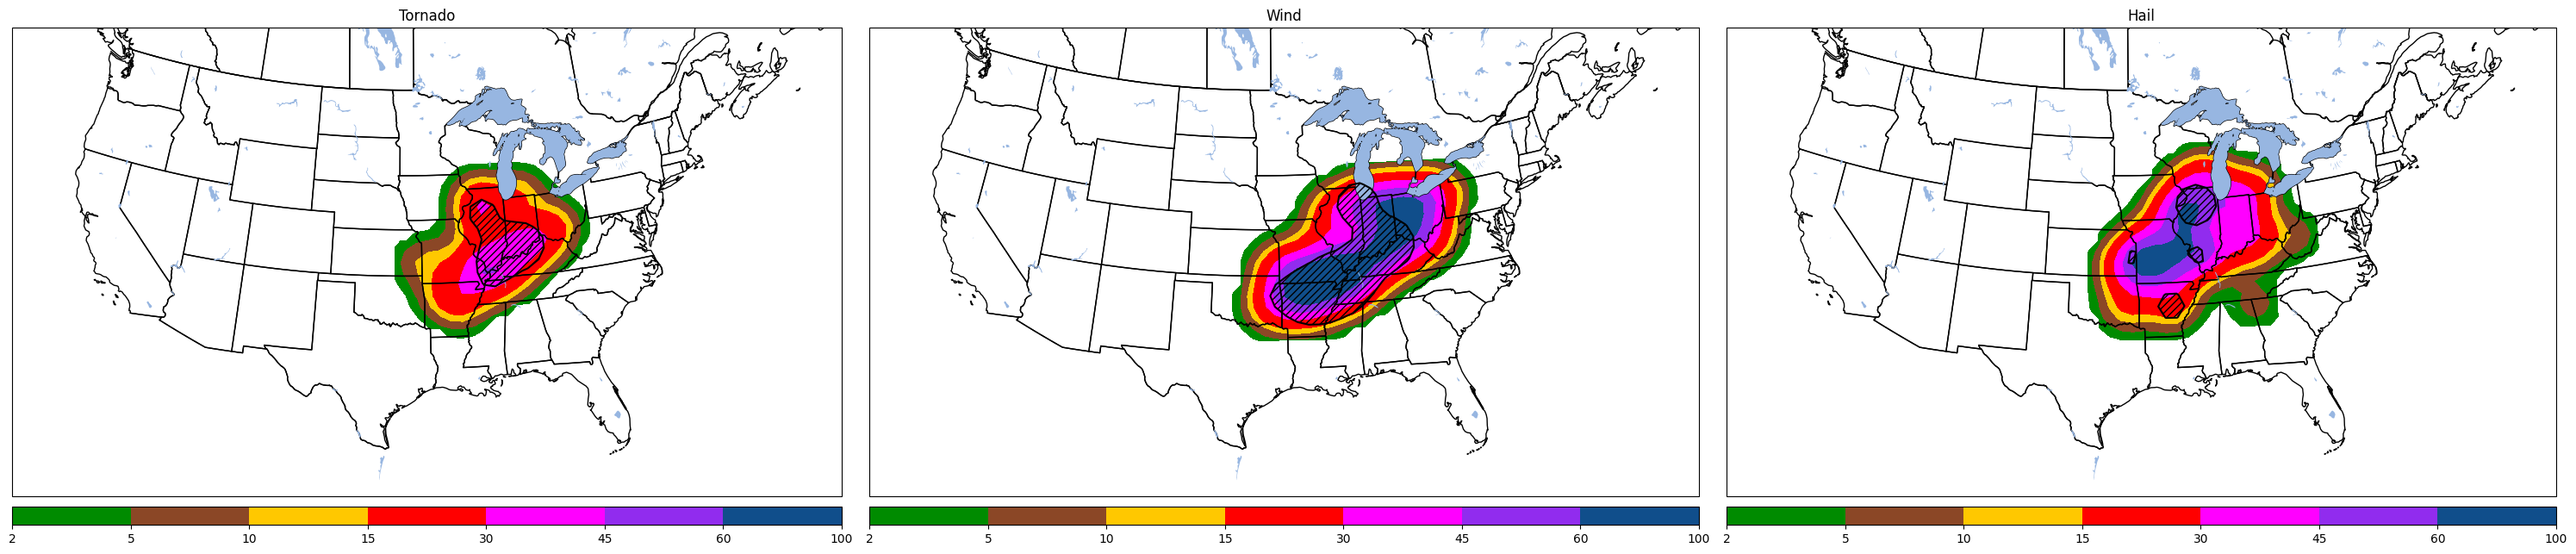

In [17]:
colors = ['#008b00','#8b4726','#ffc800', '#ff0000', '#ff00ff', '#912cee', '#104e8b']
levels = [2, 5, 10, 15, 30, 45, 60, 100]


plt.rcParams['figure.figsize'] = 30, 8
ax1 = plt.subplot(1, 3, 1, projection= ccrs.LambertConformal())
ax2 = plt.subplot(1, 3, 2, projection= ccrs.LambertConformal())
ax3 = plt.subplot(1, 3, 3, projection= ccrs.LambertConformal())



ax1.add_feature(cfeature.BORDERS)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.LAKES)
ax1.set_extent([-122, -67, 20, 50])

ax2.add_feature(cfeature.BORDERS)
ax2.add_feature(cfeature.STATES)
ax2.add_feature(cfeature.LAKES)
ax2.set_extent([-122, -67, 20, 50])

ax3.add_feature(cfeature.BORDERS)
ax3.add_feature(cfeature.STATES)
ax3.add_feature(cfeature.LAKES)
ax3.set_extent([-122, -67, 20, 50])

ax1.set_title('Tornado')
ax2.set_title('Wind')
ax3.set_title('Hail')

cm_tor = ax1.contourf(ds_tor_mask.lon, ds_tor_mask.lat, ds_tor_mask.p_perfect_tor, colors= colors, levels= levels, transform= ccrs.PlateCarree())
cm_sigtor = ax1.contour(ds_tor_sig_mask.lon, ds_tor_sig_mask.lat, ds_tor_sig_mask.p_perfect_sig_tor, levels= [10, 100], colors= 'black', zorder= 11, transform= ccrs.PlateCarree())
cm_sigtor2 = ax1.contourf(ds_tor_sig_mask.lon, ds_tor_sig_mask.lat, ds_tor_sig_mask.p_perfect_sig_tor, levels= [10, 100], colors= 'none', zorder= 11, hatches= ['////'], transform= ccrs.PlateCarree())

cm_wind = ax2.contourf(ds_wind_mask.lon, ds_wind_mask.lat, ds_wind_mask.p_perfect_wind, colors= colors, levels= levels, transform= ccrs.PlateCarree())
cm_sigwind = ax2.contour(ds_wind_sig_mask.lon, ds_wind_sig_mask.lat, ds_wind_sig_mask.p_perfect_sig_wind, levels= [10, 100], colors= 'black', zorder= 11, transform= ccrs.PlateCarree())
cm_sigwind2 = ax2.contourf(ds_wind_sig_mask.lon, ds_wind_sig_mask.lat, ds_wind_sig_mask.p_perfect_sig_wind, levels= [10, 100], colors= 'none', zorder= 11, hatches= ['////'], transform= ccrs.PlateCarree())

cm_hail = ax3.contourf(ds_hail_mask.lon, ds_hail_mask.lat, ds_hail_mask.p_perfect_hail, colors= colors, levels= levels, transform= ccrs.PlateCarree())
cm_sighail = ax3.contour(ds_hail_sig_mask.lon, ds_hail_sig_mask.lat, ds_hail_sig_mask.p_perfect_sig_hail, levels= [10, 100], colors= 'black', zorder= 11, transform= ccrs.PlateCarree())
cm_sighail2 = ax3.contourf(ds_hail_sig_mask.lon, ds_hail_sig_mask.lat, ds_hail_sig_mask.p_perfect_sig_hail, levels= [10, 100], colors= 'none', zorder= 11, hatches= ['////'], transform= ccrs.PlateCarree())



cb1 = plt.colorbar(cm_tor, orientation= 'horizontal', ax= ax1, pad= 0.015, aspect= 45)
cb2 = plt.colorbar(cm_wind, orientation= 'horizontal', ax= ax2, pad= 0.015, aspect= 45)
cb3 = plt.colorbar(cm_hail, orientation= 'horizontal', ax= ax3, pad= 0.015, aspect= 45)

# plt.tight_layout()
plt.tight_layout()